# Predicting Similar Questions

The objective of this analysis is to use different Natural Language Processing methods to predict if pairs of questions have the same meaning. The data is from Quora and hosted on Kaggle: https://www.kaggle.com/quora/question-pairs-dataset. The sections of this analysis include:
- Transforming the text
- Method 1: TfidfVectorizer 
- Method 2: Doc2Vec

In [2]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
from gensim import utils
from gensim.models.doc2vec import LabeledSentence
from gensim.models import Doc2Vec
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

In [33]:
df = pd.read_csv("questions.csv")

In [34]:
df.head(10)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
6,6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
8,8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0
9,9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0


In [35]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64

In [36]:
# Drop nulls since they can't be used by either method.
df = df.dropna()

In [37]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       0
is_duplicate    0
dtype: int64

In [38]:
df.is_duplicate.value_counts()

0    255043
1    149306
Name: is_duplicate, dtype: int64

In [39]:
255043/len(df)

0.6307496741676126

Although accuracy won't be as good of a performance metric as F1, it's still good to establish some sort of a baseline. In this case, 63.1% will be our baseline for accuracy. 

Note: 50% could also be used as the baseline. This would represent a random guess, rather than always picking the most common answer.

In [40]:
# Take a look at some of the question pairs.
print("Not duplicate:")
print(df.question1[0])
print(df.question2[0])
print()
print("Not duplicate:")
print(df.question1[1])
print(df.question2[1])
print()
print("Is duplicate:")
print(df.question1[5])
print(df.question2[5])

Not duplicate:
What is the step by step guide to invest in share market in india?
What is the step by step guide to invest in share market?

Not duplicate:
What is the story of Kohinoor (Koh-i-Noor) Diamond?
What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?

Is duplicate:
Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?
I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?


This task looks like it will be a little difficult since the first pair of questions have very similar wordings but different meanings, and the third pair have less similar wordings but the same meaning.

In [41]:
def review_to_wordlist(review, remove_stopwords=True):
    # Clean the text, with the option to remove stopwords.
    
    # Convert words to lower case and split them
    words = review.lower().split()

    # Optionally remove stop words (true by default)
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
    
    review_text = " ".join(words)

    # Clean the text
    review_text = re.sub(r"[^A-Za-z0-9(),!.?\'\`]", " ", review_text)
    review_text = re.sub(r"\'s", " 's ", review_text)
    review_text = re.sub(r"\'ve", " 've ", review_text)
    review_text = re.sub(r"n\'t", " 't ", review_text)
    review_text = re.sub(r"\'re", " 're ", review_text)
    review_text = re.sub(r"\'d", " 'd ", review_text)
    review_text = re.sub(r"\'ll", " 'll ", review_text)
    review_text = re.sub(r",", " ", review_text)
    review_text = re.sub(r"\.", " ", review_text)
    review_text = re.sub(r"!", " ", review_text)
    review_text = re.sub(r"\(", " ( ", review_text)
    review_text = re.sub(r"\)", " ) ", review_text)
    review_text = re.sub(r"\?", " ", review_text)
    review_text = re.sub(r"\s{2,}", " ", review_text)
    
    words = review_text.split()
    
    # Shorten words to their stems
    stemmer = SnowballStemmer('english')
    stemmed_words = [stemmer.stem(word) for word in words]
    
    review_text = " ".join(stemmed_words)
    
    # Return a list of words
    return(review_text)

In [42]:
def process_questions(question_list, questions, question_list_name):
# function to transform questions and display progress
    for question in questions:
        question_list.append(review_to_wordlist(question))
        if len(question_list) % 100000 == 0:
            progress = len(question_list)/len(df) * 100
            print("{} is {}% complete.".format(question_list_name, round(progress, 1)))

In [43]:
questions1 = []     
process_questions(questions1, df.question1, "questions1")
print()
questions2 = []     
process_questions(questions2, df.question2, "questions2")

questions1 is 24.7% complete.
questions1 is 49.5% complete.
questions1 is 74.2% complete.
questions1 is 98.9% complete.

questions2 is 24.7% complete.
questions2 is 49.5% complete.
questions2 is 74.2% complete.
questions2 is 98.9% complete.


In [44]:
# Take a look at some of the processed questions.
for i in range(5):
    print(questions1[i])
    print(questions2[i])
    print()

step step guid invest share market india
step step guid invest share market

stori kohinoor ( koh i noor ) diamond
would happen indian govern stole kohinoor ( koh i noor ) diamond back

increas speed internet connect use vpn
internet speed increas hack dns

mental lone solv it
find remaind math 23 24 math divid 24 23

one dissolv water quik sugar salt methan carbon di oxid
fish would surviv salt water



In [45]:
# Stores the indices of unusable questions
invalid_questions = []
for i in range(len(questions1)):
    # questions need to contain a vowel (which should be part of a full word) to be valid
    if not re.search('[aeiouyAEIOUY]', questions1[i]) or not re.search('[aeiouyAEIOUY]', questions2[i]):
    # Need to subtract 'len(invalid_questions)' to adjust for the changing index values as questions are removed.
        invalid_questions.append(i-len(invalid_questions))
print(len(invalid_questions))

352


In [46]:
# list of invalid questions
invalid_questions

[812,
 1509,
 3303,
 3397,
 3658,
 3757,
 6870,
 7361,
 7812,
 9737,
 10098,
 10573,
 10602,
 11427,
 12799,
 13001,
 13781,
 15223,
 15478,
 17469,
 17495,
 18122,
 18521,
 19854,
 20051,
 20390,
 20494,
 20770,
 23860,
 26771,
 28242,
 28950,
 31213,
 31726,
 31792,
 32672,
 32840,
 33189,
 33776,
 34723,
 35608,
 36275,
 36732,
 37156,
 38443,
 40596,
 43498,
 44958,
 47016,
 51935,
 52840,
 53702,
 53708,
 53913,
 54071,
 55463,
 55769,
 57689,
 60136,
 65318,
 67888,
 67901,
 71326,
 75837,
 76073,
 78529,
 81506,
 82678,
 88189,
 88361,
 89706,
 90436,
 91532,
 93032,
 96667,
 99295,
 99883,
 103979,
 104039,
 104900,
 105291,
 106281,
 106699,
 107444,
 108190,
 108908,
 108938,
 109072,
 109238,
 113531,
 115272,
 121566,
 122541,
 124745,
 124970,
 127211,
 127300,
 128201,
 129788,
 130255,
 130671,
 133046,
 134319,
 135136,
 136316,
 136965,
 138538,
 138850,
 138899,
 139225,
 141625,
 143805,
 144251,
 144797,
 146831,
 147188,
 148256,
 150126,
 150564,
 150965,
 151822,

These questions look pretty unusable, so it should be okay to remove them. Plus, we are only removing less than 0.09% of all of the questions.

In [47]:
# 1 = duplciate, 0 = not duplicate
print(df.is_duplicate[invalid_questions[0]])
print(questions1[invalid_questions[0]])
print(questions2[invalid_questions[0]])
print()
print(df.is_duplicate[invalid_questions[1]+1])
print(questions1[invalid_questions[1]+1])
print(questions2[invalid_questions[1]+1])
print()
print(df.is_duplicate[invalid_questions[2]+2])
print(questions1[invalid_questions[2]+2])
print(questions2[invalid_questions[2]+2])

1
gdp
signific gdp

0
204 8 503 13 305 11 907 25 705
multipli fraction python

0

cornel 's endow lowest ivi leagu


In [48]:
# Remove the invalid questions
for index in invalid_questions:
    df = df[df.id != index]
    questions1.pop(index)
    questions2.pop(index)

# These questions are also unusable, but were not detected initially.
# They were found when the function 'cosine_sim' stopped due to an error.
unexpected_invalid_questions = [36460,42273,65937,304867,306828,353918] 
for index in unexpected_invalid_questions:
    df = df[df.id != index]
    questions1.pop(index)
    questions2.pop(index)

In [49]:
# Use TfidfVectorizer() to transform the questions into vectors,
# then compute their cosine similarity.
vectorizer = TfidfVectorizer()
def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]

In [69]:
Tfidf_scores = []
for i in range(len(questions1)):
    score = cosine_sim(questions1[i], questions2[i])
    Tfidf_scores.append(score)
    if i % 40000 == 0:
        progress = i/len(questions1) * 100
        print("Similarity Scores is {}% complete.".format(round(progress,2)))

Similarity Scores is 0.0% complete.
Similarity Scores is 9.9% complete.
Similarity Scores is 19.8% complete.
Similarity Scores is 29.7% complete.
Similarity Scores is 39.6% complete.
Similarity Scores is 49.51% complete.
Similarity Scores is 59.41% complete.
Similarity Scores is 69.31% complete.
Similarity Scores is 79.21% complete.
Similarity Scores is 89.11% complete.
Similarity Scores is 99.01% complete.


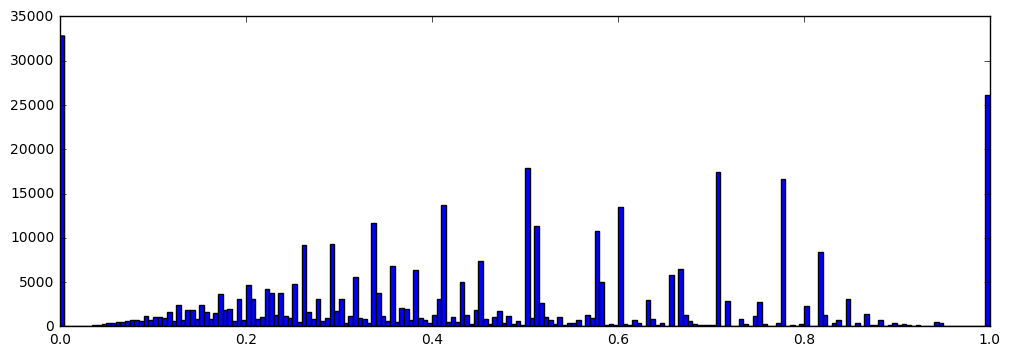

In [70]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(Tfidf_scores, bins = 200)
plt.xlim(0,1)
plt.show()

In [96]:
# Function to report the quality of the model
def performance_report(value, score_list):
    # the value (0-1) is the cosine similarity score to determine if a pair of questions
    # have the same meaning or not.
    scores = []
    for score in score_list:
        if score >= value:
            scores.append(1)
        else:
            scores.append(0)

    accuracy = accuracy_score(df.is_duplicate, scores) * 100
    print("Accuracy score is {}%.".format(round(accuracy),1))
    print()
    print("Confusion Matrix:")
    print(confusion_matrix(df.is_duplicate, scores))
    print()
    print("Classification Report:")
    print(classification_report(df.is_duplicate, scores))

In [97]:
performance_report(0.51, Tfidf_scores)

Accuracy score is 65.0%.

Confusion Matrix:
[[175988  78826]
 [ 64308  84869]]

Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.69      0.71    254814
          1       0.52      0.57      0.54    149177

avg / total       0.65      0.65      0.65    403991



Using a threshold of 0.51 for the cosine similarity maximizes both the f1-score and accuracy. It's good to see that we are scoring better than the baseline value of 63.1% accuracy. I'm not too surprised that we didn't score much above the baseline accuracy, given the difficulty of this task.

## Method 2: Doc2Vec

In [50]:
# Reset index to match the index values of questions1 and questions2
df = df.reset_index()

In [51]:
# Contains the processed questions for Doc2Vec
questions_labeled = []

for i in range(len(questions1)):
    # Question strings need to be separated into words
    # Each question needs a unique label
    questions_labeled.append(LabeledSentence(questions1[i].split(), df[df.index == i].qid1))
    questions_labeled.append(LabeledSentence(questions2[i].split(), df[df.index == i].qid2))
    if i % 40000 == 0:
        progress = i/len(questions1) * 100
        print("{}% complete".format(round(progress, 2)))

0.0% complete
9.9% complete
19.8% complete
29.7% complete
39.6% complete
49.51% complete
59.41% complete
69.31% complete
79.21% complete
89.11% complete
99.01% complete


In [52]:
# Split questions for computing similarity and determining the lengths of the questions.
questions1_split = []
for question in questions1:
    questions1_split.append(question.split())
    
questions2_split = []
for question in questions2:
    questions2_split.append(question.split())

In [53]:
# Determine the length of questions to select more optimal parameters.
lengths = []
for i in range(len(questions1_split)):
    lengths.append(len(questions1_split[i]))
    lengths.append(len(questions2_split[i]))
lengths = pd.DataFrame(lengths, columns=["count"])

In [54]:
lengths['count'].describe()

count    807982.000000
mean          5.938129
std           3.555895
min           1.000000
25%           4.000000
50%           5.000000
75%           7.000000
max         118.000000
Name: count, dtype: float64

In [55]:
# 99% of the questions include 18 or fewer words.
np.percentile(lengths['count'], 99)

18.0

In [56]:
# Build the model
model = Doc2Vec(dm = 1, min_count=1, window=10, size=150, sample=1e-4, negative=10)
model.build_vocab(questions_labeled)

In [57]:
# Train the model
for epoch in range(20):
    model.train(questions_labeled)
    print("Epoch #{} is complete.".format(epoch+1))

Epoch #1 is complete.
Epoch #2 is complete.
Epoch #3 is complete.
Epoch #4 is complete.
Epoch #5 is complete.
Epoch #6 is complete.
Epoch #7 is complete.
Epoch #8 is complete.
Epoch #9 is complete.
Epoch #10 is complete.
Epoch #11 is complete.
Epoch #12 is complete.
Epoch #13 is complete.
Epoch #14 is complete.
Epoch #15 is complete.
Epoch #16 is complete.
Epoch #17 is complete.
Epoch #18 is complete.
Epoch #19 is complete.
Epoch #20 is complete.


In [58]:
# Check a few terms to ensure the model was trained properly.
model.most_similar('good')

[('best', 0.9542202353477478),
 ('better', 0.9060102105140686),
 ('start', 0.9024202227592468),
 ('interest', 0.8957880139350891),
 ('like', 0.8842660188674927),
 ('well', 0.8825112581253052),
 ('make', 0.8812618255615234),
 ('need', 0.8797006607055664),
 ('one', 0.8790075182914734),
 ('find', 0.8748948574066162)]

In [59]:
model.most_similar('peopl')

[('person', 0.9067744016647339),
 ('other', 0.8996791243553162),
 ('them', 0.8970301151275635),
 ('someon', 0.8832480907440186),
 ('think', 0.8737582564353943),
 ('realli', 0.8734872341156006),
 ('like', 0.8638435006141663),
 ('ever', 0.8628634214401245),
 ('even', 0.8564079403877258),
 ('would', 0.8534165024757385)]

In [60]:
model.most_similar('book')

[('learn', 0.8101800084114075),
 ('read', 0.8096179366111755),
 ('write', 0.7993476986885071),
 ('best', 0.7717825174331665),
 ('blog', 0.7657737731933594),
 ('topic', 0.7641643285751343),
 ('onlin', 0.7596403956413269),
 ('english', 0.7537113428115845),
 ('must', 0.7532482147216797),
 ('one', 0.751745879650116)]

These words have appropriate similar words, so I am pleased with the training.

In [61]:
doc2vec_scores = []
for i in range(len(questions1_split)):
    # n_similarity computes the cosine similarity in Doc2Vec
    score = model.n_similarity(questions1_split[i],questions2_split[i])
    doc2vec_scores.append(score)
    if i % 100000 == 0:
        progress = i/len(questions1_split) * 100
        print("{}% complete.".format(round(progress,2)))

0.0% complete.
24.75% complete.
49.51% complete.
74.26% complete.
99.01% complete.


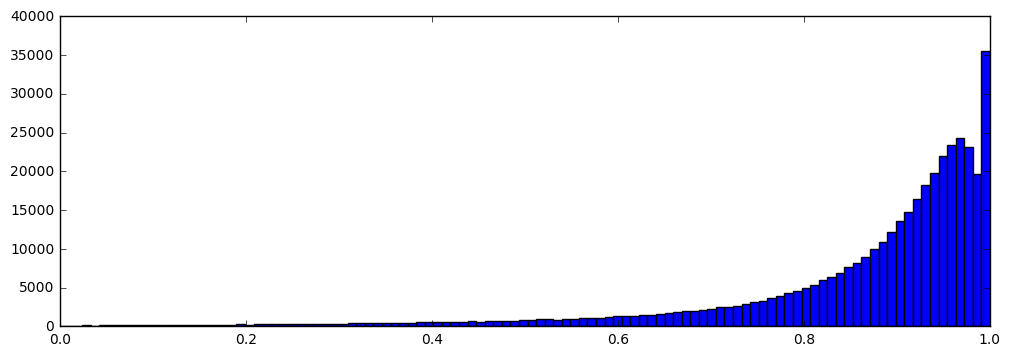

In [62]:
# Plot the scores
plt.figure(figsize=(12,4))
plt.hist(doc2vec_scores, bins = 200)
plt.xlim(0,1)
plt.show()

It's interesting to see how Doc2Vec computes the pairs of questions to be more similar than TfidfVectorizer.

In [68]:
performance_report(0.945, doc2vec_scores)

Accuracy score is 67.0%.

Confusion Matrix:
[[188058  66756]
 [ 68451  80726]]

Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.74      0.74    254814
          1       0.55      0.54      0.54    149177

avg / total       0.66      0.67      0.66    403991



Using 0.945 as our threshold, we are able to score slightly higher with the Doc2Vec method. Accuracy is 2 percentage points higher and the f1-score increased by 0.01. Much like with TfidfVectorizer, it would have been nice to score higher, but this is by no means an easy challenge. Nonetheless, I hope that you have learned something from reading this and enjoyed this project as much as I did.